<a href="https://colab.research.google.com/github/FrancescoBalzan/pymdp/blob/master/Teaching_to_Teach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install inferactively-pymdp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


Agents definition

In [ ]:
import pymdp
from pymdp import utils
from pymdp.agent import Agent


In pymdp, both generative model distributions (e.g. A or B) as well as posterior distributions over hidden states (e.g. qs) and observations are represented as what we call “object arrays”.

Their array elements can be arbitrary Python data structures or objects. The entries of an object array can thus have arbitrary type and dimensionality.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Object arrays can be initialized standard numpy constructors, but by also explicitly declaring dtype = object.

In [ ]:
my_empty_array = np.empty(5, dtype = object)

useful functions

In [ ]:
def plot_likelihood(matrix, title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")

    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

Specify the dimensionalities of the hidden state factors, the control factors, and the observation modalities for the Student

The maze in the teaching curriculum! the teacher learns how to design tha right maze to help the student achieve parameter learning (learning gravity rule in this case)

Should Inquiry have a cost?

In [ ]:
# Student Agent Hidden State Factors and Observations
context_names_S = ['Concept Learnt', 'Concept not learnt']
choice_names_S = ['Question', 'Exercise', 'Test']
gravity_params_names_S = ['Height', 'Weight', 'Distance', 'Mass', 'G', 'Radius', 'Volume', 'Density']

# Update number of states to include the new factor for gravity parameters
num_states_S = [len(context_names_S), len(choice_names_S), len(gravity_params_names_S)]
num_factors_S = len(num_states_S)

# Student Agent Control Factors
context_action_names_S = ['Do-nothing']
choice_action_names_S = ['Ask for parameter', 'Do exercises', 'Take the test']
gravity_params_action_names_S = ['Inquire about Height', 'Inquire about Weight', 'Inquire about Distance',
                             'Inquire about Mass', 'Inquire about G', 'Inquire about Radius',
                             'Inquire about Volume', 'Inquire about Density']

num_controls_S = [len(context_action_names_S), len(choice_action_names_S), len(gravity_params_action_names_S)]

# Student Agent Observations
ex_obs_names_S = ['Correct', 'Incorrect']
test_obs_names_S = ['Passed', 'Not passed']
hint_obs_names_S = ['Yes', 'No']  # Regarding the specific gravity parameters asked by the student
#question_obs_names_S = ['Simple Gravity Question', 'Gravity Question on New Planet']

num_obs_S = [len(ex_obs_names_S), len(test_obs_names_S), len(hint_obs_names_S)]
num_modalities_S = len(num_obs_S)

Specify the dimensionalities of the hidden state factors, the control factors, and the observation modalities for the Teacher

In [ ]:
# Professor Agent Hidden State Factors and Observations
context_names_T = ['Concept Learnt', 'Concept not learnt']
choice_names_T = ['Exercise', 'Hint Parameter', 'Evaluation']

# Number of states remains unchanged for the Professor
num_states_T = [len(context_names_T), len(choice_names_T)]
num_factors_T = len(num_states_T)

# Professor Agent Control Factors
context_action_names_T = ['Do-nothing']
choice_action_names_T = ['Provide exercise on Gravity','Respond Yes', 'Respond No','Evaluate Exercise']


# Update number of controls to accommodate the new hint actions
num_controls_T = [len(context_action_names_T), len(choice_action_names_T)]

# Professor Agent Observations
inquiry_obs_names_T = ['Height', 'Weight', 'Distance', 'Mass', 'G', 'Radius', 'Volume', 'Density']
ex_obs_names_T = ['Correct', 'Incorrect']
test_obs_names_T = ['Passed', 'Not passed', 'No Attempt']

relevant_parameters = ['Inquire about Mass', 'Inquire about G', 'Inquire about Radius']


# Update number of observations to incorporate the student's potential requests and the outcomes of tests
num_obs_T = [len(inquiry_obs_names_T), len(ex_obs_names_T), len(test_obs_names_T)]
num_modalities_T = len(num_obs_T)

start from here and go to A matrix definition

In [ ]:
import pymdp
from pymdp import utils
from pymdp.maths import softmax

In [ ]:

""" Generate the A array """
A_T= utils.obj_array( num_modalities_T)

A_S= utils.obj_array( num_modalities_S)


A_T by hand

In [ ]:
# A_teacher =   [  Modalità 1: [
#                       Response: [prob_correct, prob_incorrect],
#                       Request: [prob_request_spec, prob_no_request] ],
#                  Modalità 2: [
#                       Response: [prob_correct, prob_incorrect],
#                       Request:[prob_request_spec, prob_no_request] ]
#               ]

A_teacher = [
    [
        [0.2, 0.8],  # response
        [0.3, 0.7],  # request
    ], # first modality
    [
        [0.2, 0.8],  # response
        [0.3, 0.7],  # request
    ], # second modality
]
print(A_teacher)

#  alternative fill with cycle
prob_correct = 0.2
prob_incorrect = 0.8
prob_request_spec = 0.8
prob_no_request = 0.2
for modalities in range(len([1,2])):
    for obs in ['response', 'request']:
        if obs == 'response':
            A_teacher[modalities][0] = [prob_correct, prob_incorrect]
        elif obs == 'request':
            A_teacher[modalities][1] = [prob_request_spec, prob_no_request]

print(A_teacher)

# A_teacher = utils.obj_array_from_list(A_teacher)
A_teacher

# alternative with prob dist
#  alternative fill with cycle
from random import sample
prob_dist_response = sample(range(1000), 2)
prob_dist_request = sample(range(1000), 2)
for modalities in range(len([1,2])):
    for obs in ['response', 'request']:
        if obs == 'response':
            A_teacher[modalities][0] = prob_dist_response
        elif obs == 'request':
            A_teacher[modalities][1] = prob_dist_request

print(A_teacher)

Initializing the A matrix for the student A_S

In [ ]:
# Initialize A_S with uniform probabilities as a starting point
A_S = np.ones((sum(num_obs_S), sum(num_states_S), sum(num_controls_S))) / sum(num_obs_S)

# Mapping action names to indices for clarity
action_indices_S = {name: i for i, name in enumerate(gravity_params_action_names_S + choice_action_names_S)}

# Define a probability reflecting the student's confidence in their understanding and actions
p_confident = 0.7  # Adjusted based on student's confidence

# Starting indexes for each observation category within A_S matrix
start_ex_S = 0  # Exercise observations start at 0
start_test_S = start_ex_S + len(ex_obs_names_S)  # Test observations follow exercise observations
start_hint_S = start_test_S + len(test_obs_names_S)  # Hint observations follow test observations

# Populating A_S matrix with probabilities
# The student is more likely to perform correctly if they have learnt the concept
for context_idx, _ in enumerate(context_names_S):
    for action_idx, action in enumerate(choice_action_names_S + gravity_params_action_names_S):
        #'Do exercises' action leads to 'Correct' or 'Incorrect' exercise outcomes
        if action == 'Do exercises':
            for i, outcome in enumerate(ex_obs_names_S):
                index = start_ex_S + i
                A_S[index, context_idx, action_indices_S[action]] = p_confident if outcome == 'Correct' and context_idx == 0 else 1 - p_confident

        # 'Take the test' action leads to 'Passed' or 'Not passed' test outcomes
        elif action == 'Take the test':
            for i, result in enumerate(test_obs_names_S):
                index = start_test_S + i
                A_S[index, context_idx, action_indices_S[action]] = p_confident if result == 'Passed' and context_idx == 0 else 1 - p_confident

        # Assuming each parameter inquiry action leads to a 'Yes' or 'No' hint outcome
        elif action in gravity_params_action_names_S:
            for i, hint in enumerate(hint_obs_names_S):
                index = start_hint_S + i
                # Assign a high probability to 'Yes' if the concept is learnt
                A_S[index, context_idx, action_indices_S[action]] = p_confident if hint == 'Yes' and context_idx == 0 else 1 - p_confident

# Normalize the A_S matrix for each action and context
for action_idx in range(A_S.shape[2]):
    for context_idx in range(A_S.shape[1]):
        col_sum = A_S[:, context_idx, action_idx].sum()
        if col_sum > 0:  # Avoid division by zero
            A_S[:, context_idx, action_idx] /= col_sum


Initializing the A matrix for the teacher A_T

In [ ]:
# Initializing the A matrix with dimensions for each modality
# A matrix that encompasses all types of observations
total_obs_T = len(inquiry_obs_names_T) + len(ex_obs_names_T) + len(test_obs_names_T)
A_T = np.zeros((total_obs_T, len(context_names_T), len(choice_action_names_T)))

# Update probabilities for observations directly to ensure normalization
# Starting indexes for each observation category within the A_T matrix
start_ex = len(inquiry_obs_names_T)
start_test = start_ex + len(ex_obs_names_T)

p_relevant = 0.8  # Probability of making a relevant observation/action

# Assigning probabilities
for context_idx, _ in enumerate(context_names_T):
    for action_idx, action in enumerate(choice_action_names_T):
        # Inquiry observations
        if action == 'Respond Yes' or action == 'Respond No':
            for i, inquiry in enumerate(inquiry_obs_names_T):
                is_relevant = inquiry.lower() in [param.lower() for param in relevant_parameters]
                if action == 'Respond Yes':
                    A_T[i, context_idx, action_idx] = p_relevant if is_relevant else 1 - p_relevant
                else:  # 'Respond No'
                    A_T[i, context_idx, action_idx] = 1 - p_relevant if is_relevant else p_relevant

        # Exercise observations, assuming they fall under 'Evaluate Exercise'
        if action == 'Evaluate Exercise':
            for i, outcome in enumerate(ex_obs_names_T):
                index = start_ex + i
                A_T[index, context_idx, action_idx] = p_relevant if outcome == 'Correct' else 1 - p_relevant

        # Test observations, also under 'Evaluate Exercise'
        for i, result in enumerate(test_obs_names_T):
            index = start_test + i
            if result != 'No Attempt':
                A_T[index, context_idx, action_idx] = p_relevant if result == 'Passed' else 1 - p_relevant
            else:
                # Handle 'No Attempt' differently if necessary
                A_T[index, context_idx, action_idx] = 1 - p_relevant if result == 'Passed' else p_relevant

# Normalize the A matrix for each action and context
for action_idx in range(A_T.shape[2]):
    for context_idx in range(A_T.shape[1]):
        col_sum = np.sum(A_T[:, context_idx, action_idx])
        if col_sum > 0:  # Avoid division by zero
            A_T[:, context_idx, action_idx] /= col_sum

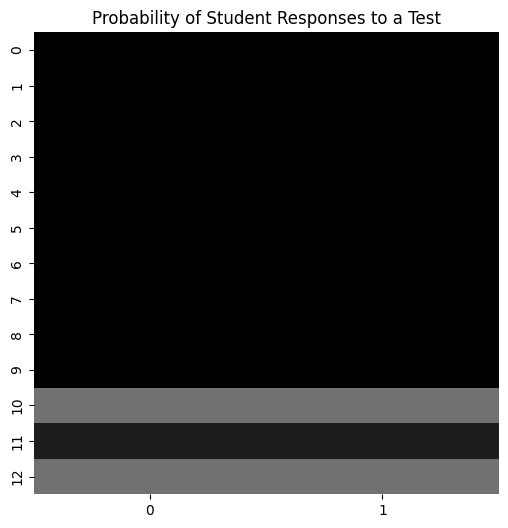

In [ ]:
plot_likelihood(A_T[:, :, 0], title_str="Probability of Student Responses to a Test")

test for error

In [ ]:
# Here we are plotting the probabilities for the 'Test' action (choice_id 0)
sns.heatmap(A_teacher[:, :, 0], annot=True, cmap='Blues', cbar=True)
plt.yticks(ticks=[0.5, 1.5], labels=['Concept Learnt', 'Concept Not Learnt'], rotation=0)
plt.xticks(ticks=[0.5, 1.5], labels=['Correct', 'Incorrect'])
plt.title("Probability of Student Responses to a Test")
plt.ylabel("Teacher's belief about student's concept understanding")
plt.xlabel("Student response to test")
plt.show()

In [ ]:
# Here we are plotting the probabilities for the 'Ask for Specification' action (choice_id 0)
sns.heatmap(A_student[:, :, 0], annot=True, cmap='Blues', cbar=True)
plt.yticks(ticks=[0.5, 1.5], labels=['Question Received', 'Hint Received'], rotation=0)
plt.xticks(ticks=[0.5, 1.5], labels=['No Hint', 'Hint Given'])
plt.title("Probability of Receiving Hints from the Teacher")
plt.ylabel("Student's perception of teacher's action")
plt.xlabel("Type of teacher's hint")
plt.show()

 choice observation modality for the student, a sub-array of A which we'll call A_choice_S

In [ ]:
A_choice_S = np.zeros((len(test_obs_names_S), len(context_names_S), len(choice_names_S)))

for choice_id in range(len(choice_names_S)):

  A_choice_S[choice_id, :, choice_id] = 1.0

A[1] = A_choice_S

In [ ]:
""" Condition on context (first hidden state factor) and display the remaining indices (outcome and choice state) """

plot_likelihood(A[1][:,0,:], "Mapping between Student's sensed states and true states")

 choice observation modality for the teacher, a sub-array of A which we'll call A_choice_T

In [ ]:
A_choice_T = np.zeros((len(response_obs_names_T), len(context_names_T), len(choice_names_T)))

for choice_id in range(len(choice_names_T)):

  A_choice_T[choice_id, :, choice_id] = 1.0

A[1] = A_choice_T

In [ ]:
plot_likelihood(A[1][:,0,:], "Mapping between Teacher's sensed states and true states")

B Matrix - transition matrix -  encodes the probabilities of transitioning from one hidden state to another given a particular action.

For the teacher agent, the B matrix could represent the probability of the student's learning state transitioning from one level of understanding to another (e.g., from 'partially understands' to 'fully understands') as a result of the teacher's actions (e.g., providing a hint, conducting a test).

For the student agent, the B matrix could reflect the change in the student's own internal state of knowledge about gravity as a consequence of their actions (e.g., studying, asking for clarification) or in response to the teacher's actions.

In [ ]:
# Assuming the teacher's model is concerned with the student's learning state
num_states_T = 2  # [Concept not learnt, Concept learnt]
num_actions_T = 2  # [Test, Provide Hint]
B_T = np.zeros((num_states_T, num_states_T, num_actions_T))

# Assuming "Test" action doesn't change the student's state directly
B_T[:, :, 0] = np.eye(num_states_T)

# Assuming "Provide Hint" can potentially lead to learning
# Placeholder probabilities for transition under "Provide Hint"
prob_hint_success = 0.2  # Chance that hint leads to learning
B_T[:, :, 1] = np.array([[0.8, prob_hint_success],
                               [0.2, 0.8]])  # Slight chance of unlearning if misconceptions are reinforced

In [ ]:
# Assuming the student's model reflects their own learning progress
num_states_S = 2  # Same as teacher, for simplicity
num_actions_S = 2  # [Ask for specification, Respond to question]
B_S = np.zeros((num_states_S, num_states_S, num_actions_S))

# Assuming "Ask for specification" doesn't change the state
B_S[:, :, 0] = np.eye(num_states_S)

# "Respond to question" might change the learning state, based on the correctness of response
prob_response_success = 0.3  # Chance of improving understanding after responding
B_S[:, :, 1] = np.array([[0.7, prob_response_success],
                               [0.3, 0.7]])  # Reflecting the learning process


In [ ]:
# Teacher Model
num_states_T = [len(context_names_T), len(choice_names_T)]
num_factors_T = len(num_states_T)

# Transition probability matrix for concept learning
B_concept_T = np.zeros((num_states_T[0], num_states_T[0], num_controls_T[1]))

# Assuming the 'Test Gravity on a different planet' action does not change the concept learning state
B_concept_T[:, :, 0] = np.eye(num_states_T[0])

B_concept_T /= B_concept_T.sum(axis=0, keepdims=True)

# Assuming the 'Provide Hint on gravity parameters' action can change the concept learning state
# Placeholder probabilities
B_concept_T[:, :, 1] = np.array([[0.9, 0.1], [0.1, 0.9]])


B_T = utils.obj_array(num_factors_T)
B_T[0] = B_concept_T  # Assign the transition matrix for concept learning to the first factor


In [ ]:
# Student Model
num_states_S = [len(context_names_S), len(choice_names_S)]
num_factors_S = len(num_states_S)

# Transition probability matrix for concept learning
B_concept_S = np.zeros((num_states_S[0], num_states_S[0], num_controls_S[1]))

# Assuming the 'Ask for specification' action does not directly change the learning state
B_concept_S[:, :, 0] = np.eye(num_states_S[0])

# Assuming the 'Respond to question' action reflects understanding and could change the learning state
# Placeholder probabilities
B_concept_S[:, :, 1] = np.array([[0.8, 0.2], [0.2, 0.8]])

B_S = utils.obj_array(num_factors_S)
B_S[0] = B_concept_S  # Assign the transition matrix for concept learning to the first factor

In [ ]:
assert all(elem is not None for elem in B_S), "Some elements of B_S are undefined"
assert all(elem is not None for elem in B_T), "Some elements of B_T are undefined"


C vector - It encodes the desirability of different observations or outcomes from the agent's perspective.

In [ ]:


# Initialize the C vectors for the teacher and the student with the correct number of observation modalities
C_T = utils.obj_array(2)
C_S = utils.obj_array(2)

# Define and assign preferences for the teacher's C vector
C_T[0] = softmax(np.array([1.0, -1.0]))  # the first modality (response) prefers correct answers over incorrect
C_T[1] = softmax(np.array([-0.5, 0.0]))  # the second modality (request) slightly disincentivizes requests

C_S[0] = softmax(np.array([1.0, -1.0]))  # Preferences for 'test' modality (Correct, Incorrect)
C_S[1] = softmax(np.zeros(2))  # Neutral preferences for 'hint' modality (Hint on G, Hint on Mass and Distance, General Hint)
#C_S[2] = softmax(np.zeros(2))  # Neutral preferences for the third modality (question)


In [ ]:
response_obs_names_T = ['Correct', 'Incorrect']  # Example, adjust as needed

# Initialize the rewards for the response observations
C_T_response = np.zeros(len(response_obs_names_T))
C_T_response[0] = -4.0  # Disliking incorrect answers
C_T_response[1] = 2.0   # Preferring correct answers

# Apply softmax to convert the rewards into preferences (probabilities)
C_T[0] = softmax(C_T_response)  # Assuming the first modality relates to response observations

# Plot the beliefs (preferences) for the teacher's prior preferences on student responses
plot_beliefs(softmax(C_T_response), title_str="Teacher Prior Preferences on Student Responses")

D Vector - the agent's belief about the state of the world before any observations are made.

In [ ]:
D_S = utils.obj_array(num_factors_S)

D_S_context = np.array([0.5,0.5])

D_S[0] = D_S_context

D_S_choice = np.zeros(len(choice_names_S))

D_S_choice[choice_names_S.index("Respond to Question")] = 1.0

D_S[1] = D_S_choice

print(f'Student beliefs about learning state: {D_S[0]}')
print(f'Student beliefs about starting location: {D_S[1]}')

In [ ]:
D_T = utils.obj_array(num_factors_S)

D_T_context = np.array([0.5,0.5])

D_T[0] = D_T_context

D_T_choice = np.zeros(len(choice_names_T))

D_T_choice[choice_names_T.index("Test")] = 1.0

D_T[1] = D_T_choice

print(f'Teacher beliefs about learning state: {D_S[0]}')
print(f'Teacher beliefs about starting location: {D_S[1]}')

Agents Construction

Normalization of the matrix

In [ ]:
def normalize_matrix(matrix):
    """
    Normalizes a given matrix so that each column sums to 1.
    Assumes the first axis represents different observations.
    """
    column_sums = matrix.sum(axis=0, keepdims=True)
    normalized_matrix = matrix / column_sums
    return normalized_matrix

# Assuming A_student is an object array of observation matrices
A_student_normalized = np.empty_like(A_student, dtype=object)

for mod_idx, matrix in enumerate(A_student):
    A_student_normalized[mod_idx] = normalize_matrix(matrix)


A_teacher_normalized = A_teacher / A_teacher.sum(axis=0, keepdims=True)

In [ ]:
from pymdp.agent import Agent

my_agent_S = Agent(A = A_student_normalized, B = B_S, C = C_S, D = D_S)

In [ ]:
my_agent_T = Agent(A = A_teacher_normalized, B = B_T, C = C_T, D = D_T)